# Analysis of Bounding Functions

This notebook analyses the approximation of the bounding functions. 

In [1]:
import numpy as np
from numpy.linalg import norm
from itertools import combinations

def orthonormalization(Q):
    n, k = Q.shape
    O = np.zeros(shape=(n, k))
    q = Q[:, 0]
    O[:, 0] =  q / norm(q)

    for i in range(1, k):
        O_i = O[:, :i]
        q = Q[:, i]
        q_orth = q - O_i.dot(O_i.T.dot(q))
        O[:, i] =  q_orth / norm(q_orth)
    return O

def non_empty_subset_indicator(d, idx=None):
    idx = np.arange(d) if idx is None else idx
    for l in range(1, len(idx)+1):
        for c in combinations(idx, l):
            col = np.zeros(d)
            col[list(c)] = 1
            yield col

class instance:
    @staticmethod
    def random(n, t, seed=None):
        rng = np.random.default_rng(seed)
        Q = rng.binomial(1, 0.5, size=(n, t))
        g = rng.normal(size=n)
        return instance(Q, g)

    def __init__(self, Q, g, keep_bf_queries=False):
        n, k = Q.shape
        self.n = n
        self.k = k
        self.Q = Q
        self.O = orthonormalization(Q)
        self.g = g
        self.P = self.O.dot(self.O.T)
        self.M = np.eye(n) - self.P
        self.g = self.M.dot(g)
        self.keep_bf_queries = keep_bf_queries

    def orth_part_norm(self, queries):
        return norm(self.M.dot(queries))

    def selected_grad_elements(self, q):
        return np.sort(self.g[np.flatnonzero(q)])

class result:
    def __init__(self, q_star, f_star, q_seq, inst):
        self.q_star = q_star
        self.f_star = f_star
        self.q_seq = q_seq
        self.inst = inst

    def print_selected_elements_by_score(self, q=None, score=None, end='\n', sep=' '):
        q = self.q_star if q is None else q
        score = self.inst.g if score is None else score
        order = np.argsort(score)[::-1]
        for i in range(self.inst.n):
            s = f'\x1b[31m{score[order[i]]:.3f}\x1b[0m' if q[order[i]] else f'{score[order[i]]:.3f}'
            print(s, end=sep if i<self.inst.n-1 else '')
        print(end, end='')

def brute_force(self, epsilon=0):
    if self.keep_bf_queries:
        bf_queries = np.zeros(shape=(2**self.n-1, self.n))
    bf_gsum_ = np.zeros(2**self.n-1)
    bf_opn_ = np.zeros(2**self.n-1)
    bf_norms_ = np.zeros(2**self.n-1)

    i_star = -1
    obj_star = float('-inf')
    q_star = None

    for i, q in enumerate(non_empty_subset_indicator(self.n)):
        if self.keep_bf_queries:
            bf_queries[i, :] = q
        bf_gsum_[i]=self.g.dot(q)
        bf_opn_[i]=self.orth_part_norm(q)
        bf_norms_[i]=norm(q)
        
        obj = (bf_gsum_[i]**2 / (bf_opn_[i] + epsilon)**2) if epsilon!=0 or bf_opn_[i]>1e-5 else 0
        if obj > obj_star:
            i_star = i
            q_star = q
            obj_star = obj

    res = result(q_star, obj_star, bf_queries if self.keep_bf_queries else None, self)
    res.i_star = i_star
    res.gsums = bf_gsum_
    res.op_norms = bf_opn_
    res.norms = bf_norms_
    return res

### Objective Function is Bounded by Squared Norm of Gradient

We can bound the objective function by decomposing $q_\perp$ into components parallel and orthogonal to the gradient vector, i.e.,
\begin{equation*}
q_\perp = q_{\perp\parallel} + q_{\perp\perp}\\
\end{equation*}
where
\begin{equation*}
q_{\perp\parallel} = \frac{q_\perp^Tg}{\|g\|^2}g \enspace .
\end{equation*}

Indeed, by observing that $\|q_{\perp\parallel}\|^2=(g^Tq)^2/\|g\|^2$ we can conclude that
\begin{align*}
\frac{(g^Tq)^2}{\|q_\perp\|^2} &= \frac{(g^Tq)^2}{\|q_{\perp\parallel}\|^2 + \|q_{\perp\perp}\|^2}\\
&\leq \frac{(g^Tq)^2}{\|q_{\perp\parallel}\|^2}\\
&=\|g\|^2
\end{align*}


### An instance of calculating the bounding function by brute-force

In [2]:
import numpy as np
from numpy.linalg import norm

RNG = np.random.default_rng(1000)
Q = RNG.binomial(1, 0.5, size=(20, 10))
g = RNG.normal(size=20)
inst1 = instance(Q[:, :5], g)

In [141]:
inst1.Q.T

array([[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]])

In [148]:
inst1.g

array([-0.39057197,  0.14296948, -0.39008365, -0.20994881,  0.9060857 ,
       -1.01544906, -0.92794419, -0.49038772,  1.11962561, -0.13715852,
       -0.00203592,  0.12999511,  0.83155099, -0.6519398 ,  1.32978487,
       -0.76365943,  0.01322645, -1.21803631,  0.59457097,  0.91504349])

In [3]:
res = brute_force(inst1)
res.f_star, norm(inst1.g)**2

(8.538267131385675, 10.75480867024855)

In [4]:
res.print_selected_elements_by_score()

1.330 1.120 0.915 0.906 0.832 0.595 0.143 0.130 0.013 -0.002 -0.137 -0.210 -0.390 -0.391 -0.490 -0.652 -0.764 -0.928 -1.015 -1.218


In [5]:
from matplotlib import pyplot as plt

def plot_solutions(res, additional_res=None, additional_res_names=None):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, tight_layout=True, squeeze=False)
    bf_obj_ = res.gsums**2 / res.op_norms**2
    axs[0, 0].scatter(res.norms**2, bf_obj_)
    axs[0, 1].scatter(res.op_norms**2, bf_obj_)
    axs[0, 2].scatter(res.gsums, bf_obj_)

    additional_res = [] if additional_res is None else additional_res
    additional_res_names = [f'$q_{i}$' for i in range(len(additional_res))]
    all_results = [res] + additional_res
    all_result_names = [r'$q^*$'] + additional_res_names
    all_res_colors = ['red', 'lime', 'gold', 'magenta', 'black', 'gray'][:len(all_results)]
    for res, name, color in zip(all_results, all_result_names, all_res_colors):
        axs[0, 0].scatter(norm(res.q_star)**2, res.f_star, edgecolors=color, facecolors='none', label=name)
        axs[0, 1].scatter(norm(res.inst.M.dot(res.q_star))**2, res.f_star, edgecolors=color, facecolors='none')
        axs[0, 2].scatter(res.q_star.dot(res.inst.g), res.f_star, edgecolors=color, facecolors='none')
    axs[0, 0].set_ylabel(r'$(q^Tg)^2/\|q_\perp\|^2$')
    axs[0, 0].set_xlabel(r'$\|q\|^2$')
    axs[0, 1].set_xlabel(r'$\|q_\perp\|^2$')
    axs[0, 2].set_xlabel(r'$q^Tg$')
    axs[0, 0].axhline(norm(res.inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 1].axhline(norm(res.inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 2].axhline(norm(res.inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 0].legend(loc='upper right')

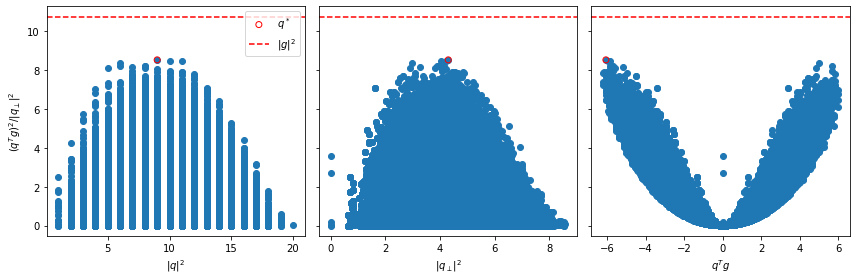

In [6]:
plot_solutions(res)

### More Systematic Test

We generate 2000 instances, each of which contains 15 data points and 5 queries. In each query, each data point has a probability of 0.5 being 1 and 0. The gradient vector is originally generated by an $n$-dimensional normal distribution. 

We use brute force to find the query which maximises of the objective function.

In [178]:
smaller_instances = []
num_instances = 2000
def brute_force_test(epsilon=0, num_inst=num_instances, display=False):
    smaller_instances_bf_f_stars=np.array([])
    for i in range(num_inst):
        inst = instance.random(15, 5, i)
        res = brute_force(inst, epsilon=epsilon)
        if display:
            print(i, end='. ')
            res.print_selected_elements_by_score(end=': ')
            print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
        if len(smaller_instances)<num_instances:
            smaller_instances.append(inst)
        smaller_instances_bf_f_stars = np.append(smaller_instances_bf_f_stars, res.f_star)
    return smaller_instances_bf_f_stars

The result of first 20 instances.

In [155]:
_=brute_force_test(epsilon=0, num_inst=20, display=True)

0. 1.109 0.836 0.512 0.220 0.134 -0.029 -0.037 -0.048 -0.106 -0.334 -0.448 -0.521 -0.549 -0.564 -0.980: -3.551  3.889
1. 0.974 0.662 0.549 0.533 0.495 0.203 0.184 -0.081 -0.147 -0.181 -0.292 -0.680 -0.728 -0.820 -1.482: -3.981  5.419
2. 1.095 0.977 0.342 0.306 0.193 0.168 0.017 -0.197 -0.205 -0.334 -0.702 -0.784 -0.903 -0.924 -1.276: -4.576  6.468
3. 1.644 0.984 0.938 0.486 0.472 0.364 0.298 0.275 -0.098 -0.162 -0.319 -0.705 -0.719 -0.767 -1.544: 4.039  8.164
4. 2.313 2.156 1.375 0.659 0.582 0.192 -0.063 -0.074 -0.428 -0.729 -0.943 -1.128 -1.307 -1.404 -1.550: -7.433  19.677
5. 1.124 1.116 1.061 0.328 0.153 -0.102 -0.173 -0.186 -0.280 -0.407 -0.412 -0.415 -0.432 -0.504 -0.572: 3.302  4.745
6. 1.171 0.995 0.909 0.738 0.317 0.009 -0.085 -0.105 -0.163 -0.221 -0.444 -0.693 -0.737 -0.759 -1.309: 3.076  6.099
7. 0.990 0.705 0.628 0.349 0.159 -0.044 -0.127 -0.135 -0.145 -0.275 -0.306 -0.546 -0.640 -0.654 -0.705: 2.673  3.277
8. 1.572 1.305 1.117 1.040 0.805 0.759 0.411 0.361 -0.215 -0.225 -0.

The below 6 cells calculates the optimal queries and the corresponding objective functions for all 2000 instances. 

(Warning: Running these cells needs about 1 hour!)

In [179]:
bfe0f = brute_force_test(epsilon=0)

In [9]:
bfe1e_3f = brute_force_test(epsilon=1e-3)

In [10]:
bfe1e_2f = brute_force_test(epsilon=1e-2)

In [11]:
bfe1e_1f = brute_force_test(epsilon=1e-1)

In [12]:
bfe1f = brute_force_test(epsilon=1)

In [13]:
bfe10f = brute_force_test(epsilon=10)

## Greedy Performance

Since calculating the optimal objective values by enumerating all the possible queries require $O(2^n)$ time in the worst case, we instead use a greedy search as a heuristic. We add one data point into the query which maximise the objective value in each iteration until the objective value cannot be improved.

In [14]:
def squared_grad_sum_by_squared_orth_norm(q, inst, epsilon):
    d = norm(inst.M.dot(q))
    return (q.dot(inst.g)**2/(norm(inst.M.dot(q)) + epsilon)**2) if epsilon!=0 or d>1e-5 else 0

def best_in_greedy(inst, epsilon=0, f = squared_grad_sum_by_squared_orth_norm):
    seq = np.zeros(shape=(inst.n+1, inst.n))
    objs = np.zeros(inst.n+1)
    for i in range(1, inst.n+1):
        seq[i, :] = np.copy(seq[i-1, :])
        j_star = -1
        obj_star = float('-inf')
        for j in range(inst.n):
            if seq[i, j]: continue    
            seq[i, j] = 1
            obj = f(seq[i, :], inst, epsilon=epsilon)
            if obj > obj_star:
                j_star = j
                obj_star = obj
            seq[i, j] = 0
        seq[i, j_star] = 1
        objs[i] = obj_star
    best_idx = np.argmax(objs)    
    return result(seq[best_idx, :], objs[best_idx], seq, inst)

The following cell shows the result of first 20 instances.

In [172]:
smaller_instances_greedy_res = []
smaller_instances_greedy_f_stars=np.array([])
for i in range(20):
    inst = smaller_instances[i]
    res = best_in_greedy(inst)
    print(i, end='. ')
    res.print_selected_elements_by_score(end=': ')
    print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
    smaller_instances_greedy_res.append(res)
    smaller_instances_greedy_f_stars = np.append(smaller_instances_greedy_f_stars, res.f_star)

0. 1.109 0.836 0.512 0.220 0.134 -0.029 -0.037 -0.048 -0.106 -0.334 -0.448 -0.521 -0.549 -0.564 -0.980: 2.628  3.512
1. 0.974 0.662 0.549 0.533 0.495 0.203 0.184 -0.081 -0.147 -0.181 -0.292 -0.680 -0.728 -0.820 -1.482: -3.981  5.419
2. 1.095 0.977 0.342 0.306 0.193 0.168 0.017 -0.197 -0.205 -0.334 -0.702 -0.784 -0.903 -0.924 -1.276: -4.576  6.468
3. 1.644 0.984 0.938 0.486 0.472 0.364 0.298 0.275 -0.098 -0.162 -0.319 -0.705 -0.719 -0.767 -1.544: 4.039  8.164
4. 2.313 2.156 1.375 0.659 0.582 0.192 -0.063 -0.074 -0.428 -0.729 -0.943 -1.128 -1.307 -1.404 -1.550: 7.140  17.097
5. 1.124 1.116 1.061 0.328 0.153 -0.102 -0.173 -0.186 -0.280 -0.407 -0.412 -0.415 -0.432 -0.504 -0.572: 3.302  4.745
6. 1.171 0.995 0.909 0.738 0.317 0.009 -0.085 -0.105 -0.163 -0.221 -0.444 -0.693 -0.737 -0.759 -1.309: -4.257  5.929
7. 0.990 0.705 0.628 0.349 0.159 -0.044 -0.127 -0.135 -0.145 -0.275 -0.306 -0.546 -0.640 -0.654 -0.705: 2.673  3.277
8. 1.572 1.305 1.117 1.040 0.805 0.759 0.411 0.361 -0.215 -0.225 -0.4

Comparing the greedy solution to the optimal solution on our first instance, we say that the greedy algorithm "picked the wrong horse": based on a good objective value for a positive gradient element, it started to grow a solution with positive sum of selected gradient elements whereas the optimum solution selects a negative sum.

### Refined Greedy Strategy with "Signed" Objectives

This suggest to a refined greedy approach to find the optimal solution that runs the greedy algorithm twice, once aiming to find the optimal "positive solution" and once the optimal "negative solution".

Indeed, when working with the non-squared objective function, we can easily split it into a positive and negative part
\begin{equation*}
\max_{q \in {\cal Q}} \frac{|g^Tq|}{\|q_\perp\|} = \max \left\{\max_{q \in {\cal Q}} \frac{g^Tq}{\|q_\perp\|}, \max_{q \in {\cal Q}}\frac{-g^Tq}{\|q_\perp\|} \right\}
\end{equation*}

In [16]:
def grad_sum_by_orth_norm(q, inst, epsilon):
    d = norm(inst.M.dot(q))
    return (q.dot(inst.g)/(norm(inst.M.dot(q)) + epsilon)) if epsilon!=0 or d>1e-5 else 0

def neg_grad_sum_by_orth_norm(q, inst, epsilon):
    d = norm(inst.M.dot(q))
    return (-q.dot(inst.g)/(norm(inst.M.dot(q)) + epsilon)) if epsilon!=0 or d>1e-5 else 0

In [17]:
def best_in_greedy_pos_neg(inst, epsilon=0):
    pos = best_in_greedy(inst, epsilon=epsilon, f=grad_sum_by_orth_norm)
    neg = best_in_greedy(inst, epsilon=epsilon, f=neg_grad_sum_by_orth_norm)
    if pos.f_star > neg.f_star:
        res = pos
    else:
        res = neg
    res.f_star = res.f_star**2
    return res

In [175]:
def greedy_pos_neg_test(epsilon=0, num_instances=num_instances, display=False):
#     smaller_instances_pn_res = []
    smaller_instances_pn_f_stars = np.array([])
    for i in range(num_instances):
        inst = smaller_instances[i]
        res = best_in_greedy_pos_neg(inst, epsilon=epsilon)
        if display:
            print(i, end='. ')
            res.print_selected_elements_by_score(end=': ')
            print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
#             smaller_instances_pn_res.append(res)
        smaller_instances_pn_f_stars = np.append(smaller_instances_pn_f_stars, res.f_star)
    return smaller_instances_pn_f_stars

The below cell shows the result of the first 20 instances.

In [176]:
_=greedy_pos_neg_test(epsilon=0, num_instances=20, display=True)

0. 1.109 0.836 0.512 0.220 0.134 -0.029 -0.037 -0.048 -0.106 -0.334 -0.448 -0.521 -0.549 -0.564 -0.980: -3.551  3.889
1. 0.974 0.662 0.549 0.533 0.495 0.203 0.184 -0.081 -0.147 -0.181 -0.292 -0.680 -0.728 -0.820 -1.482: -3.981  5.419
2. 1.095 0.977 0.342 0.306 0.193 0.168 0.017 -0.197 -0.205 -0.334 -0.702 -0.784 -0.903 -0.924 -1.276: -4.576  6.468
3. 1.644 0.984 0.938 0.486 0.472 0.364 0.298 0.275 -0.098 -0.162 -0.319 -0.705 -0.719 -0.767 -1.544: 4.039  8.164
4. 2.313 2.156 1.375 0.659 0.582 0.192 -0.063 -0.074 -0.428 -0.729 -0.943 -1.128 -1.307 -1.404 -1.550: -7.433  19.677
5. 1.124 1.116 1.061 0.328 0.153 -0.102 -0.173 -0.186 -0.280 -0.407 -0.412 -0.415 -0.432 -0.504 -0.572: 3.302  4.745
6. 1.171 0.995 0.909 0.738 0.317 0.009 -0.085 -0.105 -0.163 -0.221 -0.444 -0.693 -0.737 -0.759 -1.309: 3.076  6.099
7. 0.990 0.705 0.628 0.349 0.159 -0.044 -0.127 -0.135 -0.145 -0.275 -0.306 -0.546 -0.640 -0.654 -0.705: 2.673  3.277
8. 1.572 1.305 1.117 1.040 0.805 0.759 0.411 0.361 -0.215 -0.225 -0.

Comparing with the optimal solutions, this greedy approach identifies the optimal objective values for 18 / 20 instances with a much shorter time.

The below 6 cells calculates the queries and the corresponding objective functions using the greedy approach for all 2000 instances. 

(Warning: Running these cells needs about 1 minutes!)

In [180]:
gpne0f = greedy_pos_neg_test(epsilon=0)

In [20]:
gpne1e_3f = greedy_pos_neg_test(epsilon=1e-3)

In [21]:
gpne1e_2f = greedy_pos_neg_test(epsilon=1e-2)

In [22]:
gpne1e_1f = greedy_pos_neg_test(epsilon=1e-1)

In [23]:
gpne1f = greedy_pos_neg_test(epsilon=1)

In [24]:
gpne10f = greedy_pos_neg_test(epsilon=10)

In [181]:
len(smaller_instances)

2000

### Pre-sort greedy

In the following cells, we investigate the pre-sort greedy approach. We firstly sort the data points according to their (orthogonal projected) gradient values. Then, we can use the efficient algorithm of calculating the norms of orthogonal projections to solve the prefix optimisation prolem efficiently. 

In [25]:
def fast_para_norms_prefix(O, ext):
    deltas = O[ext]
    length = len(ext)
    okqi = np.cumsum(deltas, axis=0)
    q_para_norms = (okqi ** 2).sum(axis=1)
    q_orth_norms_sq = np.abs(np.arange(1, length + 1) - q_para_norms)
    q_orth_norms = np.sqrt(q_orth_norms_sq)
    return q_orth_norms


def pre_order_greedy(inst, epsilon=0, f = squared_grad_sum_by_squared_orth_norm):
    seq = np.zeros(shape=(inst.n+1, inst.n))
    objs = np.zeros(inst.n+1)
    order = np.argsort(inst.g)
    g = inst.g[order]
    O = inst.O[order]
    num_pre = abs(np.cumsum(g))
    num_suf = abs(np.cumsum(g[::-1]))
    ext = np.arange(inst.n)
    qs = fast_para_norms_prefix(O, ext) + epsilon
    qs_neg = fast_para_norms_prefix(O, ext[::-1]) + epsilon
    neg_bounds = np.divide(num_suf, qs_neg, out=np.zeros_like(num_suf), where=qs_neg != 0)
    pos_bounds = np.divide(num_pre, qs, out=np.zeros_like(num_suf), where=qs != 0)
    neg_max = np.argmax(neg_bounds)
    pos_max = np.argmax(pos_bounds)
#     print(pos_bounds)
#     print(neg_bounds)
    if neg_bounds[neg_max]>pos_bounds[pos_max]:
        best_seq = np.zeros(inst.n)
        selected = np.arange(0, neg_max+1)
        best_seq[order[selected]]=1
        obj = neg_bounds[neg_max]
    else:
        best_seq = np.zeros(inst.n)
        selected = np.arange(0, pos_max+1)
        best_seq[order[::-1][selected]]=1
        obj = pos_bounds[pos_max]
    return result(best_seq, obj**2, seq, inst)

In [173]:
def pre_order_greedy_test(epsilon=0, num_inst=num_instances, display=False):
    smaller_instances_pre_f_stars = np.array([])
    for i in range(num_inst):
        inst = smaller_instances[i]
        res = pre_order_greedy(inst, epsilon=epsilon)
        if display:
            print(i, end='. ')
            res.print_selected_elements_by_score(end=': ')
            print(i, f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
#             smaller_instances_pre_res.append(res)
        smaller_instances_pre_f_stars = np.append(smaller_instances_pre_f_stars, res.f_star)
    return smaller_instances_pre_f_stars

The following cell shows the results of the first 20 instances.

In [188]:
_=pre_order_greedy_test(epsilon=0, num_inst=20, display=True)

0. 1.109 0.836 0.512 0.220 0.134 -0.029 -0.037 -0.048 -0.106 -0.334 -0.448 -0.521 -0.549 -0.564 -0.980: 0 2.696  3.889
1. 0.974 0.662 0.549 0.533 0.495 0.203 0.184 -0.081 -0.147 -0.181 -0.292 -0.680 -0.728 -0.820 -1.482: 1 3.600  5.326
2. 1.095 0.977 0.342 0.306 0.193 0.168 0.017 -0.197 -0.205 -0.334 -0.702 -0.784 -0.903 -0.924 -1.276: 2 2.901  6.136
3. 1.644 0.984 0.938 0.486 0.472 0.364 0.298 0.275 -0.098 -0.162 -0.319 -0.705 -0.719 -0.767 -1.544: 3 5.463  8.164
4. 2.313 2.156 1.375 0.659 0.582 0.192 -0.063 -0.074 -0.428 -0.729 -0.943 -1.128 -1.307 -1.404 -1.550: 4 5.983  19.677
5. 1.124 1.116 1.061 0.328 0.153 -0.102 -0.173 -0.186 -0.280 -0.407 -0.412 -0.415 -0.432 -0.504 -0.572: 5 -1.508  4.745
6. 1.171 0.995 0.909 0.738 0.317 0.009 -0.085 -0.105 -0.163 -0.221 -0.444 -0.693 -0.737 -0.759 -1.309: 6 -2.804  6.099
7. 0.990 0.705 0.628 0.349 0.159 -0.044 -0.127 -0.135 -0.145 -0.275 -0.306 -0.546 -0.640 -0.654 -0.705: 7 -2.546  3.277
8. 1.572 1.305 1.117 1.040 0.805 0.759 0.411 0.361 -0

The pre-sort greedy approach is more efficient, but it only approximates the optimal objective values.

The following cells calculate the queries and objective values for all the 2000 instances. 

(Running these cells require less than 10 seconds!)

In [190]:
pree0f = pre_order_greedy_test(epsilon=0)

In [191]:
pree1e_3f = pre_order_greedy_test(epsilon=1e-3)

In [192]:
pree1e_2f = pre_order_greedy_test(epsilon=1e-2)

In [193]:
pree1e_1f = pre_order_greedy_test(epsilon=1e-1)

In [194]:
pree1f = pre_order_greedy_test(epsilon=1)

In [195]:
pree10f = pre_order_greedy_test(epsilon=10)

We define the **approximation rate** as the ratio between the objective values calculated by greedy approach and the optimal objective values. The approximation rate of the two greedy approches are calculated:

In [196]:
ratio_pn0 = gpne0f / bfe0f
ratio_pre0 = pree0f / bfe0f
ratio_pn0, ratio_pre0

(array([1.       , 1.       , 1.       , ..., 1.       , 0.9505098,
        1.       ]),
 array([1.        , 0.98281094, 0.94871012, ..., 1.        , 0.9505098 ,
        0.96073593]))

In [197]:
ratio_pn1e_3 = gpne1e_3f / bfe1e_3f
ratio_pre1e_3 = pree1e_3f / bfe1e_3f
ratio_pn1e_3, ratio_pre1e_3

(array([1.       , 1.       , 1.       , ..., 1.       , 0.9508653,
        1.       ]),
 array([1.        , 0.9829129 , 0.94888191, ..., 1.        , 0.9508653 ,
        0.96123492]))

In [198]:
ratio_pn1e_2 = gpne1e_2f / bfe1e_2f
ratio_pre1e_2 = pree1e_2f / bfe1e_2f
ratio_pn1e_2, ratio_pre1e_2

(array([1.        , 1.        , 1.        , ..., 1.        , 0.95404836,
        1.        ]),
 array([1.        , 0.98382583, 0.95042159, ..., 1.        , 0.95404836,
        0.96571204]))

In [199]:
ratio_pn1e_1 = gpne1e_1f / bfe1e_1f
ratio_pre1e_1 = pree1e_1f / bfe1e_1f
ratio_pn1e_1, ratio_pre1e_1

(array([1.        , 1.        , 1.        , ..., 1.        , 0.98432669,
        0.99092552]),
 array([1.        , 0.99251904, 0.96520381, ..., 1.        , 0.98432669,
        1.        ]))

In [200]:
ratio_pn1 = gpne1f / bfe1f
ratio_pre1 = pree1f / bfe1f
ratio_pn1, ratio_pre1

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.        , 1.        , 1.        , ..., 0.97513396, 1.        ,
        1.        ]))

In [201]:
ratio_pn10 = gpne10f / bfe10f
ratio_pre10 = pree10f / bfe10f
ratio_pn10, ratio_pre10

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.        , 1.        , 1.        , ..., 0.97813932, 1.        ,
        1.        ]))

In [202]:
kwargs = dict(width=0.25/20)

Compare the fully-greeedy approach with the pre-sort greedy approach (linear scale and log scale).

/tmp/ipykernel_10771/184828606.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, i].set_yticklabels(['%1.1f%%' %i for i in vals])


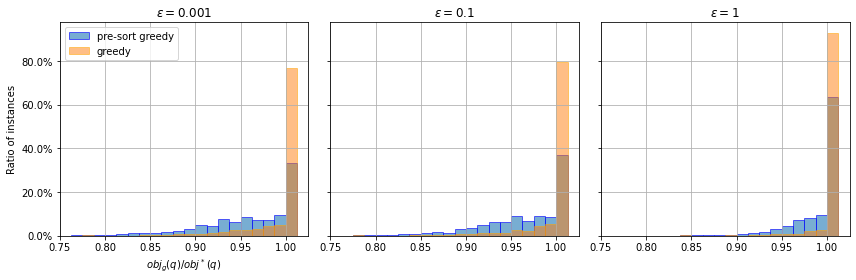

In [203]:
from matplotlib import pyplot as plt

def plot_hists(res_pns, res_pres, filename, log_scale=False):
    heights_pres=[]
    heights_pns=[]
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True, tight_layout=True, squeeze=False)
    for i in range(3):
        heights_pre, bins = np.histogram(res_pres[i], 20, range=(0.75, 1))
#         print(heights_pre/20, bins)
        heights_pn, _ = np.histogram(res_pns[i], bins)
        heights_pns.append(heights_pn)
        heights_pres.append(heights_pre)
        axs[0, i].bar(bins[1:], heights_pre/sum(heights_pre)*100, label = 'pre-sort greedy', edgecolor='blue', align="edge",alpha=0.6, **kwargs)
        axs[0, i].bar(bins[1:], heights_pn/sum(heights_pn)*100, label='greedy', align="edge", edgecolor='orange',alpha=0.5,  **kwargs)
        axs[0, i].grid()
        if log_scale:
            axs[0, i].set_yscale('log')
        vals = axs[0, i].get_yticks()
        axs[0, i].set_yticklabels(['%1.1f%%' %i for i in vals])
    axs[0, 0].set_xlabel(r"$obj_{g}(q)/obj^*(q)$")
    axs[0, 0].set_title(r"$\epsilon=0.001$")
    axs[0, 1].set_title(r"$\epsilon=0.1$")
    axs[0, 2].set_title(r"$\epsilon=1$")
    axs[0, 0].set_ylabel(r'Ratio of instances')
    axs[0, 0].legend(loc='upper left')
    fig.savefig(filename)
    return heights_pres, heights_pns
pre, pn=plot_hists([ratio_pn1e_3, ratio_pn1e_1, ratio_pn1], [ratio_pre1e_3, ratio_pre1e_1, ratio_pre1], filename='combined_greedy.pdf')

/tmp/ipykernel_10771/184828606.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, i].set_yticklabels(['%1.1f%%' %i for i in vals])


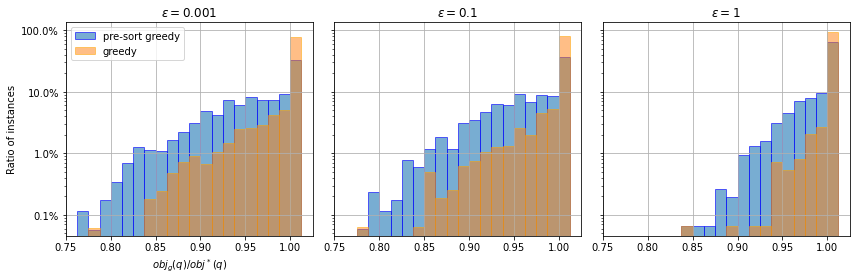

In [204]:
_,_=plot_hists([ratio_pn1e_3, ratio_pn1e_1, ratio_pn1], [ratio_pre1e_3, ratio_pre1e_1, ratio_pre1], filename='combined_greedy_log.pdf', log_scale=True)

In [205]:
from IPython.display import display, Markdown
epsilons=[0.001, 0.1, 1]
output_string=rf"""
pre-sort/obj*|$\epsilon$=0.001|$\epsilon$=0.1|$\epsilon$=1
---|---|---|---
"""
for i in range(6):
    output_string+=rf"""{75+i*5}%"""
    for j in range(3):
        output_string+=rf"""|{sum(pre[j][max(0,4*i-1):])/sum(pre[j])*100:.3f}%"""
    output_string+=rf"""
    """
display(Markdown("The following table shows the ratios of instances where the pre-sort greedy approach reaches certain approximation rates of the optimal bounding values:"))
display(Markdown(output_string))

The following table shows the ratios of instances where the pre-sort greedy approach reaches certain approximation rates of the optimal bounding values:


pre-sort/obj*|$\epsilon$=0.001|$\epsilon$=0.1|$\epsilon$=1
---|---|---|---
75%|100.000%|100.000%|100.000%
    80%|99.655%|99.705%|100.000%
    85%|96.209%|98.053%|99.934%
    90%|88.110%|90.796%|99.336%
    95%|65.537%|70.147%|92.430%
    100%|33.199%|36.873%|63.280%
    

More than 99% of the instances approximate 80% of the optimal solution when $\epsilon=0.001$ and $\epsilon=0.1$, and 90% of the optimal solution when $\epsilon=1$. 

As a reference, we also calculate the approximation rate of the fully greedy approach as following cell.

In [170]:
output_string=rf"""
greedy/obj*|$\epsilon$=0.001|$\epsilon$=0.1|$\epsilon$=1
---|---|---|---
"""
for i in range(6):
    output_string+=rf"""{75+i*5}%"""
    for j in range(3):
        output_string+=rf"""|{sum(pn[j][max(0,4*i-1):])/sum(pn[j])*100:.3f}%"""
    output_string+=rf"""
    """
display(Markdown("The following table shows the ratios of instances where the greedy approach reaches certain approximation rates of the optimal bounding values:"))
display(Markdown(output_string))

The following table shows the ratios of instances where the greedy approach reaches certain approximation rate of the optimal bounding values:


greedy/obj*|$\epsilon$=0.001|$\epsilon$=0.1|$\epsilon$=1
---|---|---|---
75%|100.000%|100.000%|100.000%
    80%|99.939%|99.937%|100.000%
    85%|99.756%|99.875%|99.933%
    90%|97.375%|98.310%|99.867%
    95%|91.697%|93.930%|99.002%
    100%|76.862%|79.599%|92.947%
    

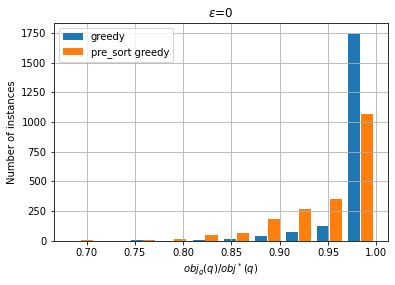

In [119]:
plt.hist([ratio_pn0, ratio_pre0], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.title(r"$\epsilon$=0")
plt.savefig("greedy_pn0.pdf")

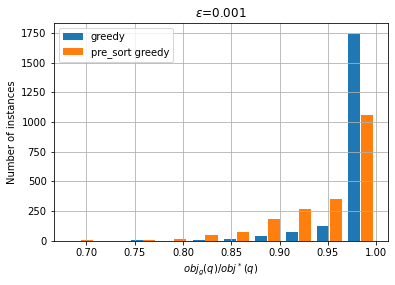

In [120]:
plt.hist([ratio_pn1e_3, ratio_pre1e_3], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.title(r"$\epsilon$=0.001")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e_3.pdf")

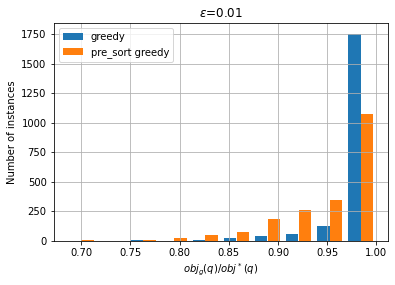

In [121]:
plt.hist([ratio_pn1e_2, ratio_pre1e_2], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.title(r"$\epsilon$=0.01")
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e_2.pdf")

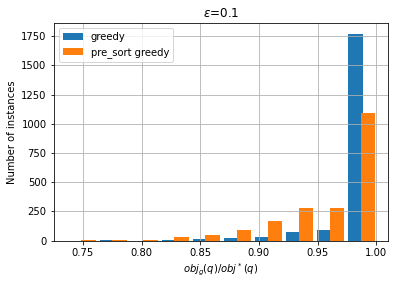

In [122]:
plt.hist([ratio_pn1e_1, ratio_pre1e_1], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.title(r"$\epsilon$=0.1")
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e_1.pdf")

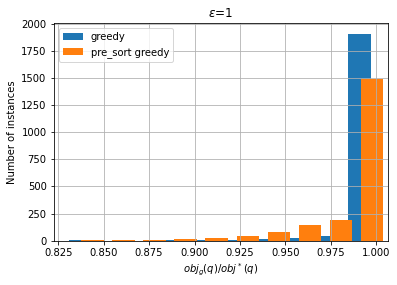

In [123]:
plt.hist([ratio_pn1, ratio_pre1], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.title(r"$\epsilon$=1")
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e0.pdf")

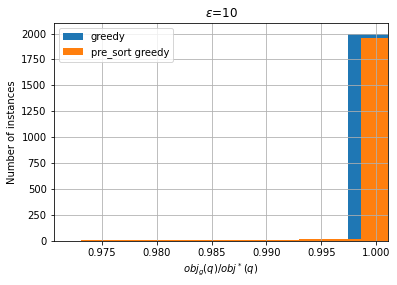

In [124]:
plt.hist([ratio_pn10, ratio_pre10], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.title(r"$\epsilon$=10")
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn10.pdf")

In [47]:
1/0
# Stop here

ZeroDivisionError: division by zero

In [165]:
import math

def compare_results_by_score(inst, *results):
    for res in results:
        res.print_selected_elements_by_score(end=': ')
        print(f'{res.f_star}')

subopt_instances = []
subopt_relgaps = []
for i, (inst, res_bf, res_greedy) in enumerate(zip(smaller_instances, smaller_instances_bf_res, smaller_instances_ref_greedy_res)):
    if not math.isclose(res_bf.f_star, res_greedy.f_star):
        gap = (res_bf.f_star - res_greedy.f_star)/res_bf.f_star
        # print('refined greedy suboptimal on instance', i, 'by', gap)
        subopt_instances.append(i)
        subopt_relgaps.append(gap)
        # compare_results_by_score(inst, res_bf, res_greedy)
    # plot_solutions(smaller_instances_bf_res[0])

subopt_instances = np.array(subopt_instances)
subopt_relgaps = np.array(subopt_relgaps)

print(len(subopt_instances), 'instances where greedy is suboptimal')
order = np.argsort(subopt_relgaps)[::-1]
print('the 10 most severe are: ')
print(subopt_instances[order[:10]])
print(subopt_relgaps[order[:10]])

NameError: name 'smaller_instances_bf_res' is not defined

In [166]:
inst, res_bf, res_greedy = smaller_instances[10], smaller_instances_bf_res[10], smaller_instances_ref_greedy_res[10]
compare_results_by_score(inst, res_bf, res_greedy)
plot_solutions(smaller_instances_bf_res[10], additional_res=[res_greedy])


NameError: name 'smaller_instances_bf_res' is not defined

In [167]:
res_greedy_neg = best_in_greedy(inst, f=neg_grad_sum_by_orth_norm)
res_greedy_neg.print_selected_elements_by_score()
print(res_greedy_neg.f_star**2)
print(norm(inst.M.dot(res_greedy_neg.q_star)))
print(norm(inst.M.dot(res_bf.q_star)))

1.484 1.293 0.835 0.794 0.554 0.524 0.481 0.426 -0.013 -0.150 -0.278 -1.094 -1.408 -1.687 -3.178
18.600596901951537
1.6168207950862348


NameError: name 'res_bf' is not defined

In [168]:
plot_solutions(smaller_instances_bf_res[69], [smaller_instances_ref_greedy_res[69]])

NameError: name 'smaller_instances_bf_res' is not defined

In [169]:
plot_solutions(smaller_instances_bf_res[3], [smaller_instances_ref_greedy_res[3]])

NameError: name 'smaller_instances_bf_res' is not defined

### Intermediate Conclusion

Despite an overall very good performance, it seems that the refined greedy algorithm does not guarantee to find the optimal solution. Eight of the 30/100 optimality violations can be attributed to numerical instability where the optimal solution is either incorrect or at least pointing to a weaknesses of the objective function itself. The other 22 appear to be genuine problems with the largest relative performance gap of about 11%.

In any case, the numerical instability motivates regularising the objective function, and it is a possibility that such regularization will also further improve the performance of the greedy algorithm outside of strictly pathological instances.

## Regularised Objective Function

Because we are interested int the signed version of the objective function for the greedy algorithm, it makes sense to apply regularization to the non-squared version:

\begin{align*}
\frac{|g^Tq|}{\|q_\perp\|+\epsilon} &\leq \frac{|g^q|}{|g^Tq|/\|g\| + \epsilon}\\
&= \frac{\|g\|}{1 + \epsilon \|g\| / |g^Tq|}
\end{align*}
